In [2]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 48.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.6 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
cd transformer

/root/Pranta/transformer


In [1]:
import time
import math
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam

from model.transformer import Transformer
from data import *
from config import *
from utils.bleu import combined_bleu_score

/fsx/neurologic/neuro_env/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/fsx/neurologic/neuro_env/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
torch.cuda.set_device(3)

In [3]:
model = Transformer(src_pad_idx=src_pad_idx,
                    trg_pad_idx=trg_pad_idx,
                    trg_sos_idx=trg_sos_idx,
                    enc_voc_size=enc_voc_size,
                    dec_voc_size=dec_voc_size,
                    d_model=d_model,
                    d_hidden=d_hidden,
                    n_layers=n_layers,
                    h=n_heads,
                    max_len=max_len,
                    drop_prob=drop_prob,
                    device=torch.device("cuda:3")).cuda()

/fsx/neurologic/pranta_root/transformer/model/transformer.py:61: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


In [4]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

54552112

In [6]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [7]:
model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (emb): TransformerEmbedding(
      (token_emb): Embedding(8015, 512)
      (pos_encoding): PositionalEncoding()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (attention): MultiHeadSelfAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=False)
          (W_K): Linear(in_features=512, out_features=512, bias=False)
          (W_V): Linear(in_features=512, out_features=512, bias=False)
          (W_T): Linear(in_features=512, out_features=512, bias=False)
          (softmax): Softmax(dim=-1)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (layer_norm1): LayerNorm()
        (ffn): PositionwiseFeedForward(
          (layer1): Linear(in_features=512, out_features=2048, bias=True)
          (layer2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (relu): ReLU()
        )
    

In [8]:
optimizer = Adam(params=model.parameters(),
                 betas=(0.9, 0.98),
                 eps=1e-9)

def rate(step, d_model, factor, warmup_steps):
    if step == 0:
        step = 1
    return factor * (
          d_model ** (-0.5) * min(step ** (-0.5), warmup_steps * step ** (-1.5))
      )

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                              lr_lambda=lambda step : rate(step, d_model=512, factor=1.0, warmup_steps=4000))

class LabelSmoothing(nn.Module):
    def __init__(self, dec_voc_size, padding_idx, smoothing=0.1):
        super(LabelSmoothing, self).__init__()
        self.size = dec_voc_size
        self.padding_idx = padding_idx
        self.eps = smoothing
        self.conf = 1 - smoothing
        self.criterion = nn.CrossEntropyLoss() #nn.KLDivLoss(reduction='sum')
        self.true_dist = None
            
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.eps/(self.size - 2))
        true_dist.scatter_(1, target.unsqueeze(1), self.conf)
        true_dist[:, self.padding_idx] = 0

        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
              true_dist.index_fill_(0, mask.squeeze(), 0.0)

        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())


In [9]:
# Loss = LabelSmoothing(dec_voc_size, en_vocab['<pad>'])
Loss = nn.CrossEntropyLoss(ignore_index = trg_pad_idx, label_smoothing=0.1)

In [10]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for batch in tqdm(iterator):
        src = batch[0].T.to(device)
        trg = batch[1].T.to(device)

        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output_reshape, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
    lr = optimizer.param_groups[0]["lr"]
        # print('step :', round((i / len(iterator)) *  100, 2), '% , loss :', loss.item())

    return epoch_loss / len(iterator), lr

# val_batch_size=6
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    batch_bleu = []
    with torch.no_grad():
        for batch in tqdm(iterator):
            src = batch[0].T.to(device)
            trg = batch[1].T.to(device)
            output = model(src, trg[:, :-1])
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg_reshape = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output_reshape, trg_reshape)
            epoch_loss += loss.item()

            # total_bleu = []
            # for j in range(val_batch_size):
            #     try:
            #         trg_words = idx_to_word(trg[j], trg_itos)
            #         output_words = output[j].max(dim=1)[1]      # Greedy Decoding
            #         output_words = idx_to_word(output_words, trg_itos)
            #         bleu = avg_bleu(trg_words.split(), output_words.split())
            #         total_bleu.append(bleu)
            #     except:
            #       pass

            # total_bleu = sum(total_bleu) / len(total_bleu)
            # batch_bleu.append(total_bleu)

    # epoch_bleu = sum(batch_bleu) / len(batch_bleu)
    return epoch_loss / len(iterator)

In [11]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
def save_last_5_checkpoints(step):
    if step in range(459, 500, 10):
        torch.save(model.state_dict(), f'./saved_model/model_epoch_{step+1}.pt')

In [4]:
def idx_to_words(x, itos):
    words = []
    for i in x:
        word = itos[i.item()]
        if '<' not in word:
            words.append(word)
    return " ".join(words)

In [14]:
def run(total_epoch, best_loss):
    train_losses, test_losses = [], []
    for step in range(total_epoch):
        start_time = time.time()
        train_loss, lr = train(model, train_iter, optimizer, Loss, clip)
        valid_loss = evaluate(model, val_iter, Loss)
        end_time = time.time()

        # if step > 3:
        #     scheduler.step()

        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        # bleus.append(bleu)
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), './saved_model/best_model.pt')

        f = open('./result/train_loss.txt', 'w')
        f.write(str(train_losses))
        f.close()

        # f = open('/content/drive/MyDrive/transformer/result/bleu.txt', 'w')
        # f.write(str(bleus))
        # f.close()

        f = open('./result/test_loss.txt', 'w')
        f.write(str(test_losses))
        f.close()
        
        save_last_5_checkpoints(step)

        print(f'Epoch: {step + 1} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | lr: {lr}')
        print(f'\tVal Loss: {valid_loss:.3f} ')
        # print(f'\tBLEU Score: {bleu:.3f}')

In [ ]:
if __name__ == '__main__':
    run(total_epoch=500, best_loss=inf)

100%|██████████| 169/169 [00:02<00:00, 72.93it/s]


Epoch: 1 | Time: 1m 25s
	Train Loss: 7.197 | lr: 2.595171245429374e-06
	Val Loss: 6.677 


100%|██████████| 169/169 [00:02<00:00, 73.42it/s]


Epoch: 2 | Time: 1m 25s
	Train Loss: 6.597 | lr: 1.8350631859834486e-06
	Val Loss: 6.313 


100%|██████████| 169/169 [00:02<00:00, 73.01it/s]


Epoch: 3 | Time: 1m 25s
	Train Loss: 6.322 | lr: 1.4983228171418255e-06
	Val Loss: 6.114 


100%|██████████| 169/169 [00:02<00:00, 73.39it/s]


Epoch: 4 | Time: 1m 24s
	Train Loss: 6.143 | lr: 1.297585622714687e-06
	Val Loss: 5.973 


100%|██████████| 169/169 [00:02<00:00, 73.09it/s]


Epoch: 5 | Time: 1m 24s
	Train Loss: 6.013 | lr: 1.1605958636065741e-06
	Val Loss: 5.861 


100%|██████████| 169/169 [00:02<00:00, 74.04it/s]


Epoch: 6 | Time: 1m 25s
	Train Loss: 5.911 | lr: 1.0594742244075163e-06
	Val Loss: 5.773 


100%|██████████| 169/169 [00:02<00:00, 73.59it/s]


Epoch: 7 | Time: 1m 25s
	Train Loss: 5.829 | lr: 9.808825321474133e-07
	Val Loss: 5.695 


100%|██████████| 169/169 [00:02<00:00, 73.45it/s]


Epoch: 8 | Time: 1m 25s
	Train Loss: 5.762 | lr: 9.175315929917243e-07
	Val Loss: 5.642 


100%|██████████| 169/169 [00:02<00:00, 73.25it/s]


Epoch: 9 | Time: 1m 25s
	Train Loss: 5.706 | lr: 8.650570818097915e-07
	Val Loss: 5.592 


100%|██████████| 169/169 [00:02<00:00, 73.25it/s]


Epoch: 10 | Time: 1m 25s
	Train Loss: 5.660 | lr: 8.206652053732661e-07
	Val Loss: 5.550 


100%|██████████| 169/169 [00:02<00:00, 73.11it/s]


Epoch: 11 | Time: 1m 25s
	Train Loss: 5.621 | lr: 7.824735716189601e-07
	Val Loss: 5.524 


100%|██████████| 169/169 [00:02<00:00, 74.31it/s]


Epoch: 12 | Time: 1m 25s
	Train Loss: 5.589 | lr: 7.491614085709127e-07
	Val Loss: 5.493 


100%|██████████| 169/169 [00:02<00:00, 73.80it/s]


Epoch: 13 | Time: 1m 24s
	Train Loss: 5.561 | lr: 7.197709995388732e-07
	Val Loss: 5.467 


100%|██████████| 169/169 [00:02<00:00, 73.59it/s]


Epoch: 14 | Time: 1m 25s
	Train Loss: 5.538 | lr: 6.833386108658795e-07
	Val Loss: 5.446 


100%|██████████| 169/169 [00:02<00:00, 73.80it/s]


Epoch: 15 | Time: 1m 24s
	Train Loss: 5.519 | lr: 6.161566292171235e-07
	Val Loss: 5.432 


100%|██████████| 169/169 [00:02<00:00, 73.47it/s]


Epoch: 16 | Time: 1m 25s
	Train Loss: 5.503 | lr: 5.593041477218479e-07
	Val Loss: 5.421 


100%|██████████| 169/169 [00:02<00:00, 74.11it/s]


Epoch: 17 | Time: 1m 25s
	Train Loss: 5.490 | lr: 5.106867992588496e-07
	Val Loss: 5.403 


100%|██████████| 169/169 [00:02<00:00, 73.62it/s]


Epoch: 18 | Time: 1m 25s
	Train Loss: 5.479 | lr: 4.687262288591184e-07
	Val Loss: 5.398 


100%|██████████| 169/169 [00:02<00:00, 73.60it/s]


Epoch: 19 | Time: 1m 25s
	Train Loss: 5.470 | lr: 4.322127882322756e-07
	Val Loss: 5.397 


100%|██████████| 169/169 [00:02<00:00, 73.12it/s]


Epoch: 20 | Time: 1m 25s
	Train Loss: 5.461 | lr: 4.0020547020916355e-07
	Val Loss: 5.382 


100%|██████████| 169/169 [00:02<00:00, 74.15it/s]


Epoch: 23 | Time: 1m 25s
	Train Loss: 5.443 | lr: 3.2451610891662667e-07
	Val Loss: 5.365 


100%|██████████| 169/169 [00:02<00:00, 73.87it/s]


Epoch: 24 | Time: 1m 24s
	Train Loss: 5.439 | lr: 3.044466162090564e-07
	Val Loss: 5.361 


100%|██████████| 169/169 [00:02<00:00, 73.00it/s]


Epoch: 25 | Time: 1m 25s
	Train Loss: 5.434 | lr: 2.8636372363358613e-07
	Val Loss: 5.356 


100%|██████████| 169/169 [00:02<00:00, 73.44it/s]


Epoch: 26 | Time: 1m 25s
	Train Loss: 5.431 | lr: 2.7000262847499015e-07
	Val Loss: 5.355 


100%|██████████| 169/169 [00:02<00:00, 72.67it/s]


Epoch: 27 | Time: 1m 24s
	Train Loss: 5.427 | lr: 2.551422421697447e-07
	Val Loss: 5.350 


100%|██████████| 169/169 [00:02<00:00, 73.63it/s]


Epoch: 28 | Time: 1m 25s
	Train Loss: 5.424 | lr: 2.415966827949294e-07
	Val Loss: 5.351 


100%|██████████| 169/169 [00:02<00:00, 73.69it/s]


Epoch: 29 | Time: 1m 25s
	Train Loss: 5.421 | lr: 2.2920865733525254e-07
	Val Loss: 5.348 


100%|██████████| 169/169 [00:02<00:00, 73.31it/s]


Epoch: 30 | Time: 1m 25s
	Train Loss: 5.418 | lr: 2.1784426539623662e-07
	Val Loss: 5.343 


100%|██████████| 169/169 [00:02<00:00, 73.63it/s]


Epoch: 31 | Time: 1m 25s
	Train Loss: 5.415 | lr: 2.0738888335775054e-07
	Val Loss: 5.342 


100%|██████████| 169/169 [00:02<00:00, 73.67it/s]


Epoch: 32 | Time: 1m 24s
	Train Loss: 5.413 | lr: 1.9774387779994057e-07
	Val Loss: 5.339 


100%|██████████| 169/169 [00:02<00:00, 73.80it/s]


Epoch: 33 | Time: 1m 25s
	Train Loss: 5.410 | lr: 1.8882396121545433e-07
	Val Loss: 5.337 


100%|██████████| 169/169 [00:02<00:00, 74.24it/s]


Epoch: 34 | Time: 1m 25s
	Train Loss: 5.409 | lr: 1.805550494091928e-07
	Val Loss: 5.335 


100%|██████████| 169/169 [00:02<00:00, 73.83it/s]


Epoch: 35 | Time: 1m 25s
	Train Loss: 5.407 | lr: 1.7287251387773315e-07
	Val Loss: 5.330 


100%|██████████| 169/169 [00:02<00:00, 74.26it/s]


Epoch: 36 | Time: 1m 25s
	Train Loss: 5.404 | lr: 1.6571974747314012e-07
	Val Loss: 5.332 


100%|██████████| 169/169 [00:02<00:00, 74.02it/s]


Epoch: 37 | Time: 1m 25s
	Train Loss: 5.403 | lr: 1.5904698029173232e-07
	Val Loss: 5.328 


100%|██████████| 169/169 [00:02<00:00, 73.53it/s]


Epoch: 175 | Time: 1m 25s
	Train Loss: 5.345 | lr: 1.546218769887548e-08
	Val Loss: 5.260 


100%|██████████| 169/169 [00:02<00:00, 73.27it/s]


Epoch: 176 | Time: 1m 25s
	Train Loss: 5.346 | lr: 1.533059505523041e-08
	Val Loss: 5.256 


100%|██████████| 169/169 [00:02<00:00, 73.97it/s]


Epoch: 177 | Time: 1m 25s
	Train Loss: 5.345 | lr: 1.520085843455401e-08
	Val Loss: 5.260 


100%|██████████| 169/169 [00:02<00:00, 73.54it/s]


Epoch: 178 | Time: 1m 24s
	Train Loss: 5.345 | lr: 1.507294139341474e-08
	Val Loss: 5.258 


100%|██████████| 169/169 [00:02<00:00, 62.69it/s]


Epoch: 179 | Time: 1m 25s
	Train Loss: 5.345 | lr: 1.4946808403272287e-08
	Val Loss: 5.257 


100%|██████████| 169/169 [00:02<00:00, 73.85it/s]


Epoch: 180 | Time: 1m 25s
	Train Loss: 5.345 | lr: 1.4822424822561613e-08
	Val Loss: 5.257 


100%|██████████| 169/169 [00:02<00:00, 56.61it/s]


Epoch: 181 | Time: 1m 27s
	Train Loss: 5.344 | lr: 1.469975686977803e-08
	Val Loss: 5.260 


100%|██████████| 169/169 [00:02<00:00, 71.99it/s]


Epoch: 182 | Time: 1m 25s
	Train Loss: 5.345 | lr: 1.4578771597522263e-08
	Val Loss: 5.260 


100%|██████████| 169/169 [00:03<00:00, 47.27it/s]


Epoch: 183 | Time: 1m 26s
	Train Loss: 5.344 | lr: 1.4459436867466094e-08
	Val Loss: 5.260 


100%|██████████| 169/169 [00:02<00:00, 72.70it/s]


Epoch: 184 | Time: 1m 25s
	Train Loss: 5.344 | lr: 1.4341721326201183e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:02<00:00, 60.78it/s]


Epoch: 185 | Time: 1m 26s
	Train Loss: 5.345 | lr: 1.4225594381935311e-08
	Val Loss: 5.257 


100%|██████████| 169/169 [00:02<00:00, 73.27it/s]


Epoch: 186 | Time: 1m 25s
	Train Loss: 5.344 | lr: 1.4111026182001858e-08
	Val Loss: 5.256 


100%|██████████| 169/169 [00:02<00:00, 73.82it/s]


Epoch: 187 | Time: 1m 25s
	Train Loss: 5.344 | lr: 1.3997987591150016e-08
	Val Loss: 5.259 


100%|██████████| 169/169 [00:02<00:00, 73.95it/s]


Epoch: 188 | Time: 1m 25s
	Train Loss: 5.344 | lr: 1.3886450170584598e-08
	Val Loss: 5.260 


100%|██████████| 169/169 [00:02<00:00, 72.30it/s]


Epoch: 189 | Time: 1m 25s
	Train Loss: 5.344 | lr: 1.377638615772574e-08
	Val Loss: 5.258 


100%|██████████| 169/169 [00:02<00:00, 59.61it/s]


Epoch: 190 | Time: 1m 26s
	Train Loss: 5.344 | lr: 1.3667768446660118e-08
	Val Loss: 5.254 


100%|██████████| 169/169 [00:02<00:00, 73.46it/s]


Epoch: 191 | Time: 1m 25s
	Train Loss: 5.344 | lr: 1.3560570569256557e-08
	Val Loss: 5.256 


100%|██████████| 169/169 [00:02<00:00, 73.77it/s]


Epoch: 192 | Time: 1m 25s
	Train Loss: 5.344 | lr: 1.3454766676920128e-08
	Val Loss: 5.258 


100%|██████████| 169/169 [00:02<00:00, 73.74it/s]


Epoch: 193 | Time: 1m 25s
	Train Loss: 5.343 | lr: 1.335033152295994e-08
	Val Loss: 5.254 


100%|██████████| 169/169 [00:02<00:00, 72.76it/s]


Epoch: 194 | Time: 1m 25s
	Train Loss: 5.343 | lr: 1.3247240445546929e-08
	Val Loss: 5.257 


100%|██████████| 169/169 [00:03<00:00, 53.54it/s]


Epoch: 195 | Time: 1m 58s
	Train Loss: 5.343 | lr: 1.3145469351239005e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:02<00:00, 71.44it/s]


Epoch: 196 | Time: 1m 25s
	Train Loss: 5.343 | lr: 1.3044994699051845e-08
	Val Loss: 5.257 


100%|██████████| 169/169 [00:02<00:00, 70.81it/s]


Epoch: 197 | Time: 1m 25s
	Train Loss: 5.343 | lr: 1.2945793485054601e-08
	Val Loss: 5.258 


100%|██████████| 169/169 [00:02<00:00, 71.27it/s]


Epoch: 198 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.2847843227470668e-08
	Val Loss: 5.256 


100%|██████████| 169/169 [00:02<00:00, 71.55it/s]


Epoch: 199 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.2751121952264486e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 71.56it/s]


Epoch: 200 | Time: 1m 25s
	Train Loss: 5.343 | lr: 1.2655608179196196e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:02<00:00, 71.50it/s]


Epoch: 201 | Time: 1m 25s
	Train Loss: 5.343 | lr: 1.2561280908326692e-08
	Val Loss: 5.259 


100%|██████████| 169/169 [00:02<00:00, 71.25it/s]


Epoch: 202 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.2468119606956375e-08
	Val Loss: 5.258 


100%|██████████| 169/169 [00:02<00:00, 70.21it/s]


Epoch: 203 | Time: 1m 25s
	Train Loss: 5.343 | lr: 1.2376104196981613e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 71.71it/s]


Epoch: 204 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.2285215042653546e-08
	Val Loss: 5.258 


100%|██████████| 169/169 [00:02<00:00, 71.64it/s]


Epoch: 205 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.2195432938724593e-08
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 71.97it/s]


Epoch: 206 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.210673909896846e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:02<00:00, 71.31it/s]


Epoch: 207 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.2019115145060246e-08
	Val Loss: 5.257 


100%|██████████| 169/169 [00:02<00:00, 70.97it/s]


Epoch: 208 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.1932543095803597e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 69.22it/s]


Epoch: 209 | Time: 1m 25s
	Train Loss: 5.341 | lr: 1.1847005356692511e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 68.06it/s]


Epoch: 210 | Time: 1m 25s
	Train Loss: 5.342 | lr: 1.1762484709795832e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:04<00:00, 37.56it/s]


Epoch: 211 | Time: 1m 57s
	Train Loss: 5.342 | lr: 1.1678964303952994e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:04<00:00, 36.33it/s]


Epoch: 212 | Time: 3m 12s
	Train Loss: 5.340 | lr: 1.1596427645270024e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:04<00:00, 37.40it/s]


Epoch: 213 | Time: 3m 12s
	Train Loss: 5.342 | lr: 1.1514858587905207e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:04<00:00, 37.66it/s]


Epoch: 214 | Time: 3m 12s
	Train Loss: 5.341 | lr: 1.1434241325134312e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:04<00:00, 37.62it/s]


Epoch: 215 | Time: 3m 10s
	Train Loss: 5.341 | lr: 1.1354560380685626e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:04<00:00, 37.23it/s]


Epoch: 216 | Time: 3m 12s
	Train Loss: 5.342 | lr: 1.127580060033542e-08
	Val Loss: 5.251 


100%|██████████| 169/169 [00:05<00:00, 33.21it/s]


Epoch: 217 | Time: 3m 12s
	Train Loss: 5.341 | lr: 1.1197947143754895e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:04<00:00, 37.23it/s]


Epoch: 218 | Time: 3m 12s
	Train Loss: 5.341 | lr: 1.112098547659992e-08
	Val Loss: 5.252 


100%|██████████| 169/169 [00:05<00:00, 33.22it/s]


Epoch: 219 | Time: 3m 13s
	Train Loss: 5.340 | lr: 1.1044901362835297e-08
	Val Loss: 5.256 


100%|██████████| 169/169 [00:04<00:00, 36.81it/s]


Epoch: 220 | Time: 3m 12s
	Train Loss: 5.341 | lr: 1.0969680857285547e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:04<00:00, 36.97it/s]


Epoch: 221 | Time: 3m 12s
	Train Loss: 5.340 | lr: 1.0895310298404538e-08
	Val Loss: 5.254 


100%|██████████| 169/169 [00:04<00:00, 37.37it/s]


Epoch: 222 | Time: 3m 12s
	Train Loss: 5.340 | lr: 1.0821776301256572e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:02<00:00, 71.93it/s]


Epoch: 223 | Time: 1m 49s
	Train Loss: 5.340 | lr: 1.0749065750701837e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 71.51it/s]


Epoch: 224 | Time: 1m 25s
	Train Loss: 5.341 | lr: 1.0677165794779367e-08
	Val Loss: 5.255 


100%|██████████| 169/169 [00:02<00:00, 70.34it/s]


Epoch: 225 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.0606063838280967e-08
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 71.46it/s]


Epoch: 226 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.0535747536509737e-08
	Val Loss: 5.256 


100%|██████████| 169/169 [00:02<00:00, 71.92it/s]


Epoch: 227 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.0466204789217122e-08
	Val Loss: 5.254 


100%|██████████| 169/169 [00:02<00:00, 71.51it/s]


Epoch: 228 | Time: 1m 25s
	Train Loss: 5.341 | lr: 1.0397423734712626e-08
	Val Loss: 5.257 


100%|██████████| 169/169 [00:02<00:00, 72.12it/s]


Epoch: 229 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.032939274414053e-08
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 72.15it/s]


Epoch: 230 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.026210041591817e-08
	Val Loss: 5.256 


100%|██████████| 169/169 [00:02<00:00, 71.67it/s]


Epoch: 231 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.0195535570330565e-08
	Val Loss: 5.250 


100%|██████████| 169/169 [00:02<00:00, 70.73it/s]


Epoch: 232 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.01296872442763e-08
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 71.62it/s]


Epoch: 233 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.0064544686159837e-08
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 71.60it/s]


Epoch: 234 | Time: 1m 25s
	Train Loss: 5.340 | lr: 1.0000097350925563e-08
	Val Loss: 5.254 


100%|██████████| 169/169 [00:02<00:00, 71.05it/s]


Epoch: 235 | Time: 1m 24s
	Train Loss: 5.340 | lr: 9.936334895229027e-09
	Val Loss: 5.251 


100%|██████████| 169/169 [00:02<00:00, 71.29it/s]


Epoch: 236 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.873247172741047e-09
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 71.34it/s]


Epoch: 237 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.810824229580465e-09
	Val Loss: 5.254 


100%|██████████| 169/169 [00:02<00:00, 70.17it/s]


Epoch: 238 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.749056299871504e-09
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 71.09it/s]


Epoch: 239 | Time: 1m 25s
	Train Loss: 5.340 | lr: 9.687933801421837e-09
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 71.81it/s]


Epoch: 240 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.627447331517554e-09
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 71.20it/s]


Epoch: 241 | Time: 1m 25s
	Train Loss: 5.340 | lr: 9.567587662831467e-09
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 71.91it/s]


Epoch: 242 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.50834573944117e-09
	Val Loss: 5.251 


100%|██████████| 169/169 [00:02<00:00, 71.37it/s]


Epoch: 243 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.449712672953508e-09
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 72.31it/s]


Epoch: 244 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.39167973873219e-09
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 71.17it/s]


Epoch: 245 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.334238372225389e-09
	Val Loss: 5.253 


100%|██████████| 169/169 [00:02<00:00, 71.35it/s]


Epoch: 246 | Time: 1m 25s
	Train Loss: 5.338 | lr: 9.277380165390247e-09
	Val Loss: 5.250 


100%|██████████| 169/169 [00:02<00:00, 71.66it/s]


Epoch: 247 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.22109686321141e-09
	Val Loss: 5.248 


100%|██████████| 169/169 [00:02<00:00, 71.22it/s]


Epoch: 248 | Time: 1m 25s
	Train Loss: 5.338 | lr: 9.165380360310708e-09
	Val Loss: 5.251 


100%|██████████| 169/169 [00:02<00:00, 71.10it/s]


Epoch: 249 | Time: 1m 25s
	Train Loss: 5.338 | lr: 9.110222697645237e-09
	Val Loss: 5.256 


100%|██████████| 169/169 [00:02<00:00, 71.84it/s]


Epoch: 250 | Time: 1m 25s
	Train Loss: 5.338 | lr: 9.055616059291211e-09
	Val Loss: 5.251 


100%|██████████| 169/169 [00:02<00:00, 71.87it/s]


Epoch: 251 | Time: 1m 25s
	Train Loss: 5.339 | lr: 9.001552769311038e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 71.17it/s]


Epoch: 252 | Time: 1m 25s
	Train Loss: 5.339 | lr: 8.948025288701088e-09
	Val Loss: 5.250 


100%|██████████| 169/169 [00:02<00:00, 72.17it/s]


Epoch: 253 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.895026212417827e-09
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 72.13it/s]


Epoch: 254 | Time: 1m 25s
	Train Loss: 5.339 | lr: 8.842548266479965e-09
	Val Loss: 5.250 


100%|██████████| 169/169 [00:02<00:00, 71.99it/s]


Epoch: 255 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.790584305144419e-09
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 71.45it/s]


Epoch: 256 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.739127308153874e-09
	Val Loss: 5.248 


100%|██████████| 169/169 [00:02<00:00, 71.95it/s]


Epoch: 257 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.688170378053925e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 71.93it/s]


Epoch: 258 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.637706737577728e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 71.39it/s]


Epoch: 259 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.587729727096222e-09
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 71.17it/s]


Epoch: 260 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.538232802132043e-09
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 72.00it/s]


Epoch: 261 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.48920953093528e-09
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 71.57it/s]


Epoch: 262 | Time: 1m 24s
	Train Loss: 5.337 | lr: 8.440653592119336e-09
	Val Loss: 5.250 


100%|██████████| 169/169 [00:02<00:00, 72.08it/s]


Epoch: 263 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.392558772355139e-09
	Val Loss: 5.252 


100%|██████████| 169/169 [00:02<00:00, 70.48it/s]


Epoch: 264 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.344918964122087e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 71.50it/s]


Epoch: 265 | Time: 1m 25s
	Train Loss: 5.338 | lr: 8.297728163514109e-09
	Val Loss: 5.248 


100%|██████████| 169/169 [00:02<00:00, 71.74it/s]


Epoch: 266 | Time: 1m 24s
	Train Loss: 5.337 | lr: 8.250980468099261e-09
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 71.64it/s]


Epoch: 267 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.20467007483142e-09
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 71.48it/s]


Epoch: 268 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.158791278012539e-09
	Val Loss: 5.251 


100%|██████████| 169/169 [00:02<00:00, 71.50it/s]


Epoch: 269 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.113338467304128e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 71.00it/s]


Epoch: 270 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.068306125786543e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 71.33it/s]


Epoch: 271 | Time: 1m 25s
	Train Loss: 5.337 | lr: 8.023688828064782e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 71.29it/s]


Epoch: 272 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.979481238419525e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 70.70it/s]


Epoch: 273 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.935678109002113e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 71.42it/s]


Epoch: 274 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.892274278072369e-09
	Val Loss: 5.250 


100%|██████████| 169/169 [00:02<00:00, 72.01it/s]


Epoch: 275 | Time: 1m 24s
	Train Loss: 5.337 | lr: 7.849264668277967e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 69.13it/s]


Epoch: 276 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.806644284974346e-09
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 69.37it/s]


Epoch: 277 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.764408214583957e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 70.27it/s]


Epoch: 278 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.72255162299389e-09
	Val Loss: 5.244 


100%|██████████| 169/169 [00:02<00:00, 69.16it/s]


Epoch: 279 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.68106975399076e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 68.26it/s]


Epoch: 280 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.639957927731912e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 69.95it/s]


Epoch: 281 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.599211539251964e-09
	Val Loss: 5.249 


100%|██████████| 169/169 [00:02<00:00, 70.47it/s]


Epoch: 282 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.558826057003707e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 70.20it/s]


Epoch: 283 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.518797021432547e-09
	Val Loss: 5.244 


100%|██████████| 169/169 [00:02<00:00, 70.30it/s]


Epoch: 284 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.479120043583489e-09
	Val Loss: 5.243 


100%|██████████| 169/169 [00:02<00:00, 71.21it/s]


Epoch: 285 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.4397908037398956e-09
	Val Loss: 5.245 


100%|██████████| 169/169 [00:02<00:00, 70.08it/s]


Epoch: 286 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.400805050093151e-09
	Val Loss: 5.248 


100%|██████████| 169/169 [00:02<00:00, 70.41it/s]


Epoch: 287 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.362158597442418e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 71.24it/s]


Epoch: 288 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.323847325923725e-09
	Val Loss: 5.248 


100%|██████████| 169/169 [00:02<00:00, 71.13it/s]


Epoch: 289 | Time: 1m 25s
	Train Loss: 5.337 | lr: 7.2858671797676094e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 71.14it/s]


Epoch: 290 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.248214166084583e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 68.94it/s]


Epoch: 291 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.210884353677703e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 60.83it/s]


Epoch: 292 | Time: 1m 26s
	Train Loss: 5.336 | lr: 7.173873871881552e-09
	Val Loss: 5.245 


100%|██████████| 169/169 [00:02<00:00, 70.95it/s]


Epoch: 293 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.137178909426952e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 70.50it/s]


Epoch: 294 | Time: 1m 25s
	Train Loss: 5.335 | lr: 7.100795713330762e-09
	Val Loss: 5.240 


100%|██████████| 169/169 [00:02<00:00, 71.78it/s]


Epoch: 295 | Time: 1m 25s
	Train Loss: 5.336 | lr: 7.064720587810109e-09
	Val Loss: 5.245 


100%|██████████| 169/169 [00:02<00:00, 73.08it/s]


Epoch: 296 | Time: 1m 25s
	Train Loss: 5.335 | lr: 7.0289498932204444e-09
	Val Loss: 5.244 


100%|██████████| 169/169 [00:02<00:00, 73.75it/s]


Epoch: 297 | Time: 1m 25s
	Train Loss: 5.336 | lr: 6.9934800450168276e-09
	Val Loss: 5.243 


100%|██████████| 169/169 [00:02<00:00, 73.87it/s]


Epoch: 298 | Time: 1m 25s
	Train Loss: 5.336 | lr: 6.9583075127378376e-09
	Val Loss: 5.244 


100%|██████████| 169/169 [00:02<00:00, 73.31it/s]


Epoch: 299 | Time: 1m 24s
	Train Loss: 5.335 | lr: 6.923428819011562e-09
	Val Loss: 5.243 


100%|██████████| 169/169 [00:02<00:00, 73.93it/s]


Epoch: 300 | Time: 1m 24s
	Train Loss: 5.336 | lr: 6.888840538583105e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 72.79it/s]


Epoch: 301 | Time: 1m 25s
	Train Loss: 5.335 | lr: 6.8545392973630735e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 73.19it/s]


Epoch: 302 | Time: 1m 24s
	Train Loss: 5.337 | lr: 6.820521771496524e-09
	Val Loss: 5.247 


100%|██████████| 169/169 [00:02<00:00, 73.72it/s]


Epoch: 303 | Time: 1m 25s
	Train Loss: 5.335 | lr: 6.786784686451883e-09
	Val Loss: 5.246 


100%|██████████| 169/169 [00:02<00:00, 72.62it/s]


Epoch: 304 | Time: 1m 24s
	Train Loss: 5.335 | lr: 6.753324816129306e-09
	Val Loss: 5.245 


 56%|█████▌    | 162/290 [00:45<00:37,  3.42it/s]

In [18]:
with open('./result/test_loss.txt') as g:
    data = g.read()

In [10]:
import pandas as pd

In [20]:
df = pd.DataFrame(
    {
        "epoch" : [i for i in range(1, 101)],
        "Loss" : [float(i) for i in data[1:-1].split(",")]
    }
)

<Axes: xlabel='epoch'>

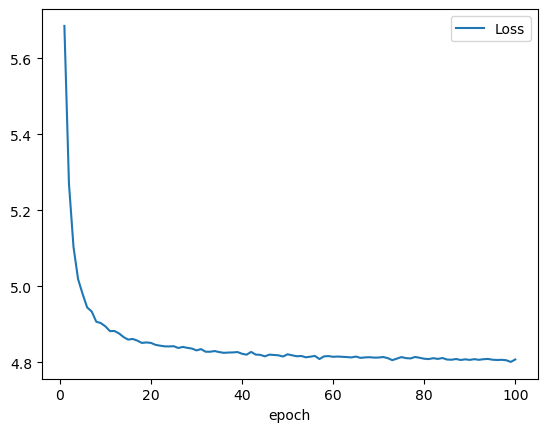

In [21]:
# Cross Entropy without label smoothing
df.plot(x="epoch", y="Loss", kind="line")

In [6]:
with open("./logs/test_run") as f:
    data = f.read()

In [11]:
import matplotlib.pyplot as plt

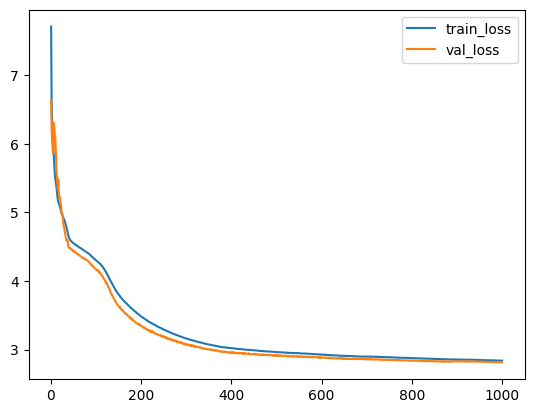

In [25]:
lines = data.split("\n")
train_loss, val_loss = [], []
for idx in range(0, len(lines[:-1]), 8):
    candidate = lines[idx: idx + 8]
    tmp_train_loss = 0.0
    tmp_val_loss = 0.0
    for l in candidate:
        tmp = l.split()
        tmp_train_loss += float(tmp[3])
        tmp_val_loss += float(tmp[5])
    train_loss.append(tmp_train_loss / 8)
    val_loss.append(tmp_val_loss / 8)

plt.plot(list(range(1, 1001)), train_loss, label="train_loss")
plt.plot(list(range(1, 1001)), val_loss, label="val_loss")
plt.legend(loc="upper right")
plt.show()

## Test

In [5]:
def modified_state_dict(model_path):
    state_dict = torch.load(model_path)
    clean_state_dict = {k.replace('module.', ''):v for k, v in state_dict.items()}
    return clean_state_dict

In [6]:
new_state_dict = modified_state_dict('./saved_model/final_model.pt')
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [14]:
bleu_scores = []
model.eval()
for batch in tqdm(test_iter):
    src = batch[0].T.to(device)
    trg = batch[1].T.to(device)
    
    outputs = model(src, trg[:, :-1])
    output_indices = outputs[0].max(dim=1)[1]
    candidate_words = idx_to_words(output_indices, trg_itos)
    reference_words = idx_to_words(trg[0], trg_itos)
    bleu_score = combined_bleu_score(reference_words.split(), candidate_words.split())
    bleu_scores.append(bleu_score)
    
print(f"BLEU : {sum(bleu_scores)/1000}")

100%|██████████| 1000/1000 [00:15<00:00, 63.28it/s]

BLEU : 5.423783096773601


In [31]:
src_words = idx_to_words(src[0], src_itos)
src_words

'Ein Mann in einer schwarzen Jacke spielt in der Öffentlichkeit Gitarre . \n'

In [16]:
trg_words = idx_to_words(trg[0], trg_itos)
trg_words

'A girl wearing black athletic clothing with the number on her jersey runs across some grass . \n'

In [15]:
candidate_words

'A girl in a shorts shorts is a ball of on her head is down the grass . \n'

In [37]:
output_indices

tensor([ 26,  33,  18,  22, 118,  35,  36,  22,  49,  14,  76,  22,  14,  15,
          3], device='cuda:1')

## Checkpoint Averaging

In [39]:
checkpoint1 = torch.load('./saved_model/model_epoch_60.pt')
checkpoint2 = torch.load('./saved_model/model_epoch_70.pt')
checkpoint3 = torch.load('./saved_model/model_epoch_80.pt')
checkpoint4 = torch.load('./saved_model/model_epoch_90.pt')
checkpoint5 = torch.load('./saved_model/model_epoch_100.pt')

In [40]:
checkpoints = [
    checkpoint1,
    checkpoint2,
    checkpoint3,
    checkpoint4,
    checkpoint5
]

In [55]:
layer_names = [i for i in checkpoints[0]]

In [41]:
def checkpoint_averaging(checkpoints):
    n = len(checkpoints)
    for l in checkpoints[0]:
        for i in range(1, n):
            checkpoints[0][l] += checkpoints[i][l]
        checkpoints[0][l] /= 5 
            
    return checkpoints[0]

In [42]:
new_checkpoint = checkpoint_averaging(checkpoints)

In [80]:
new_checkpoint

OrderedDict([('encoder.emb.token_emb.weight',
              tensor([[ 0.1312,  0.1490, -0.1369,  ...,  0.1302, -0.1701, -0.1484],
                      [ 0.0220, -0.0051, -0.0232,  ..., -0.0183,  0.0242,  0.0103],
                      [ 0.1497,  0.1667,  0.1270,  ...,  0.1277, -0.1487,  0.1565],
                      ...,
                      [ 0.0176, -0.0148,  0.0084,  ...,  0.0236, -0.0034,  0.0160],
                      [ 0.0059, -0.0002, -0.0263,  ..., -0.0255,  0.0024,  0.0092],
                      [-0.0128, -0.0261, -0.0141,  ..., -0.0227,  0.0129,  0.0123]],
                     device='cuda:0')),
             ('encoder.layers.0.attention.W_Q.weight',
              tensor([[-0.1981,  0.1201, -0.0984,  ..., -0.1208,  0.1695, -0.1017],
                      [ 0.2132, -0.0798,  0.1896,  ...,  0.0898,  0.2055,  0.2268],
                      [ 0.1804,  0.1908,  0.0882,  ...,  0.1052, -0.1688,  0.1715],
                      ...,
                      [-0.0897,  0.0778, -0.0967

In [43]:
model.load_state_dict(new_checkpoint)

<All keys matched successfully>

## Decoding Strategy

In [7]:
def greedy_decoding(src, start_symbol):
    src_mask = model.make_src_mask(src)
    enc_rep = model.encoder(src, src_mask)
    
    ys = torch.zeros(1, 1).fill_(en_vocab[start_symbol]).type_as(src.data).cuda()
    max_len = src.size()[1] + 20 - 2
    for i in range(max_len - 1):
        trg_mask = model.make_trg_mask(ys)
        output = model.decoder(ys, enc_rep, trg_mask, src_mask)
        # if i == 0:
        # output_idx = torch.randint(len(output[0]), (1,)).item()
        # else:
        output_idx = output[0].max(dim=1)[1][-1]
        if output_idx == en_vocab['<eos>']:
            break
        else:
            ys = torch.cat([ys, torch.zeros(1, 1).type_as(src.data).fill_(output_idx)], dim=1)
        
    return ys

In [20]:
idx = 150

de_sample = test_data[idx][0]
en_sample = test_data[idx][1]
src = torch.cat([torch.tensor(de_vocab['<sos>']).reshape(1), de_sample, torch.tensor(de_vocab['<eos>']).reshape(1)], dim=0).unsqueeze(0).cuda()

print('### SOURCE TEXT ###')
print(idx_to_words(src[0], src_itos))

print('### TARGET TEXT ###')
print(idx_to_words(en_sample, trg_itos))

start_symbol = '<sos>'
ys = greedy_decoding(src, start_symbol)
print('### GENERATED TEXT ###')
print(idx_to_words(ys.squeeze(), trg_itos))

### SOURCE TEXT ###
Eine Person in einer rosa Jacke sitzt auf einer hölzernen Bank . 

### TARGET TEXT ###
An individual wearing rose jacket site idle on a wooden bench . 

### GENERATED TEXT ###
A person in a blue shirt is sitting on a bench in a blue jacket . 



## Beam Search

In [12]:
def get_log_prob(logits, token_id):
    # Compute the softmax of the logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)
    log_probabilities = torch.log(probabilities)
    
    # Get the log probability of the token
    token_log_probability = log_probabilities[token_id].item()
    return token_log_probability

In [13]:
from tqdm.notebook import tqdm
import numpy as np
import networkx as nx

def greedy_sampling(logits, beams):
    return torch.topk(logits, beams).indices
    
def beam_search(input_ids, node, bar, length, beams, sampling, enc_rep, src_mask, temperature=0.1):
    if length == 0:
        return None
    
    trg_mask = model.make_trg_mask(input_ids)
    outputs = model.decoder(input_ids, enc_rep, trg_mask, src_mask)
    predictions = outputs

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):
        bar.update(1)

        # Compute the score of the predicted token
        token_score = get_log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        token = idx_to_words([token_id], trg_itos)#tokenizer.decode(token_id, skip_special_tokens=True)
        current_node = list(graph.successors(node))[j]
        graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
        graph.nodes[current_node]['cumscore'] = cumulative_score
        graph.nodes[current_node]['sequencescore'] = 1/(len(new_input_ids.squeeze())) * cumulative_score
        graph.nodes[current_node]['token'] = token + f"_{length}_{j}"

        # Recursive call
        beam_search(new_input_ids, current_node, bar, length-1, beams, sampling, enc_rep, src_mask, 1)

In [23]:
idx = 300

de_sample = test_data[idx][0]
en_sample = test_data[idx][1]
src = torch.cat([torch.tensor(de_vocab['<sos>']).reshape(1), de_sample, torch.tensor(de_vocab['<eos>']).reshape(1)], dim=0).unsqueeze(0).cuda()

src_mask = model.make_src_mask(src)
enc_rep = model.encoder(src, src_mask)

start_symbol = '<sos>'
ys = torch.zeros(1, 1).fill_(en_vocab[start_symbol]).type_as(src.data).cuda()

In [24]:
print('### SOURCE TEXT ###')
print(idx_to_words(src[0], src_itos))

print('### TARGET TEXT ###')
print(idx_to_words(en_sample, trg_itos))

### SOURCE TEXT ###
Ein Junger Mann rutscht mit dem Skateboard über ein rosa Geländer . 

### TARGET TEXT ###
A young man skateboards off a pink railing . 



In [25]:
# Parameters
length = 10
beams = 2

# Create a balanced tree with height 'length' and branching factor 'k'
graph = nx.balanced_tree(beams, length, create_using=nx.DiGraph())
bar = tqdm(total=len(graph.nodes))

# Add 'tokenscore', 'cumscore', and 'token' attributes to each node
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['cumscore'] = 0
    graph.nodes[node]['sequencescore'] = 0
    graph.nodes[node]['token'] = '<sos>'

# Start generating text
beam_search(ys, 0, bar, length, beams, 'greedy', enc_rep, src_mask, 1)

  0%|          | 0/2047 [00:00<?, ?it/s]

In [26]:
def get_best_sequence(G):
    # Create a list of leaf nodes
    leaf_nodes = [node for node in G.nodes() if G.out_degree(node)==0]

    # Get the leaf node with the highest cumscore
    max_score_node = None
    max_score = float('-inf')
    for node in leaf_nodes:
        if G.nodes[node]['sequencescore'] > max_score:
            max_score = G.nodes[node]['sequencescore']
            max_score_node = node

    # Retrieve the sequence of nodes from this leaf node to the root node in a list
    path = nx.shortest_path(G, source=0, target=max_score_node)

    # Return the string of token attributes of this sequence
    sequence = " ".join([G.nodes[node]['token'].split('_')[0] for node in path])
    
    return sequence, max_score

sequence, max_score = get_best_sequence(graph)
print(f"Generated text: {sequence[5:]}")

Generated text:  A young man is jumping on a skateboard with his


## Attention Visulization

In [64]:
sample = next(iter(test_iter))

In [49]:
def idx_to_words_new(x, itos):
    words = []
    for i in x:
        word = itos[i.item()]
        words.append(word)
    return words

In [65]:
src = sample[0].T.cuda()
trg = sample[1].T.cuda()

output = model(src, trg[:, :-1])

In [66]:
source_labels = idx_to_words_new(src.squeeze(), src_itos)
target_labels = idx_to_words_new(trg.squeeze(), trg_itos)

In [71]:
att = model.decoder.layers[4].enc_dec_attention.score

In [54]:
import matplotlib.pyplot as plt

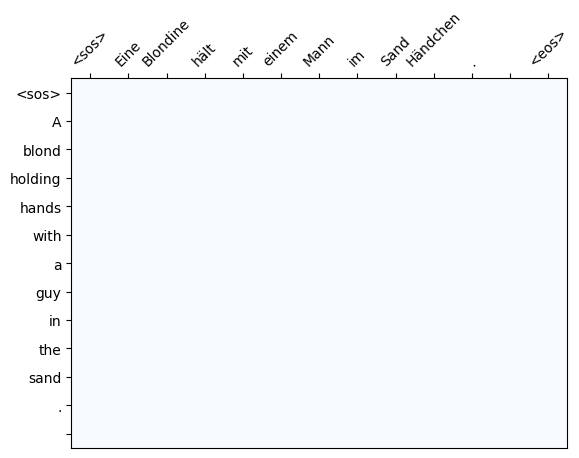

In [72]:
import numpy as np

fig, ax = plt.subplots()
heatmap = ax.pcolor(att.squeeze()[0].cpu().detach().numpy(), cmap=plt.cm.Blues)

ax.set_xticks(np.arange(att.squeeze()[0].shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(att.squeeze()[0].shape[0]) + 0.5, minor=False)

ax.set_xlim(0, int(att.squeeze()[0].shape[1]))
ax.set_ylim(0, int(att.squeeze()[0].shape[0]))

source_labels = idx_to_words_new(src.squeeze(), src_itos)
target_labels = idx_to_words_new(trg.squeeze(), trg_itos)

ax.invert_yaxis()
ax.xaxis.tick_top()

# source words -> column labels
ax.set_xticklabels(source_labels, minor=False)
# target words -> row labels
ax.set_yticklabels(target_labels[:-1], minor=False)

plt.xticks(rotation=45)

# plt.tight_layout()
plt.show()